In [160]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
cities = pd.read_csv('WDataFiles/WCities.csv')
gameCities = pd.read_csv('WDataFiles/WGameCities.csv')
tourneyResults = pd.read_csv('WDataFiles/WNCAATourneyCompactResults.csv')
seeds = pd.read_csv('WDataFiles/WNCAATourneySeeds.csv')
slots = pd.read_csv('WDataFiles/WNCAATourneySlots.csv')
seasonResults = pd.read_csv('WDataFiles/WRegularSeasonCompactResults.csv')
seasons = pd.read_csv('WDataFiles/WSeasons.csv')
teams = pd.read_csv('WDataFiles/WTeams.csv')
spellings = pd.read_csv('WDataFiles/WTeamSpellings.csv', encoding='latin1')

### Head

In [3]:
cities.head(2)

,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH


In [4]:
gameCities.head(2)

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2015,11,3103,3127,Regular,4002
1,2015,11,3104,3197,Regular,4353


In [5]:
tourneyResults.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,137,3104,94,3422,46,H,0
1,1998,137,3112,75,3365,63,H,0


In [6]:
seeds.head(2)

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163


In [7]:
slots.head(2)

,Slot,StrongSeed,WeakSeed
0,R1W1,W01,W16
1,R1W2,W02,W15


In [8]:
seasonResults.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0


In [9]:
seasons.head(2)

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1998,10/27/1997,East,Midwest,Mideast,West
1,1999,10/26/1998,East,Mideast,Midwest,West


In [10]:
teams.head(2)

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force


In [11]:
spellings.head(2)

,TeamNameSpelling,TeamID
0,a&m-corpus chris,3394
1,abilene chr,3101


## Build Team Table

In [12]:
def rs_win_percent(df):
    '''
    Determine percent of wins in regular season
    '''
    for team, year in df.index:
        season = seasonResults[ seasonResults.Season == year ]
        wins = len(season[ season.WTeamID == team ])
        losses = len(season[ season.LTeamID == team ])
        win_perc = wins / (wins + losses)
        df.set_value((team, year), 'rs_win_perc', win_perc)

In [13]:
def last_games_percent(df, games=10):
    '''
    Determine percent of wins in last x games of regular season
    '''
    for team, year in df.index:
        season = seasonResults[ (seasonResults.Season == year) & ((seasonResults.WTeamID == team) | (seasonResults.LTeamID == team)) ].sort_values('DayNum', ascending=False).head(games)
        wins = len(season[ season.WTeamID == team ])
        losses = len(season[ season.LTeamID == team ])
        win_perc = wins / (wins + losses)
        df.set_value((team, year), 'last_{}_perc'.format(games), win_perc)

In [14]:
def seed_ranking(row, df):
    '''
    Create rough ranking from seed (treat all regions equally)
    '''
    seed_loc = df.columns.get_loc("Seed")
    seed = row[seed_loc]
    return int(seed[1:]) * 4

In [30]:
tt = seeds.set_index(['TeamID', 'Season']).join(teams.set_index('TeamID'))
rs_win_percent(tt)
last_games_percent(tt, 5)
last_games_percent(tt, 10)
last_games_percent(tt, 15)
tt['seed_ranking'] = tt.apply(seed_ranking, df=tt, axis=1)
tt.head()

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,,Seed,TeamName,rs_win_perc,last_5_perc,last_10_perc,last_15_perc,seed_ranking
TeamID,Season,,,,,,,
3330,1998,W01,Old Dominion,0.925926,1.0,0.9,0.866667,4
3163,1998,W02,Connecticut,0.937500,1.0,0.9,0.933333,8
3112,1998,W03,Arizona,0.777778,0.8,0.8,0.800000,12
3301,1998,W04,NC State,0.777778,0.6,0.6,0.666667,16
3272,1998,W05,Memphis,0.846154,1.0,0.9,0.933333,20


## Build tourney results table

In [77]:
tourneyResultsByID = pd.DataFrame(columns=['Season', 'lowID', 'highID', 'lowWon?'])
for index, row in tourneyResults.iterrows():
    year = row['Season']
    winningID = row['WTeamID']
    losingID = row['LTeamID']
    
    if int(winningID) > int(losingID):
        highID = winningID
        lowID = losingID
        lowWon = 0
    else:
        highID = losingID
        lowID = winningID
        lowWon = 1
        
    tourneyResultsByID = tourneyResultsByID.append({'Season': year, 'lowID': lowID, 'highID': highID, 'lowWon?': lowWon}, ignore_index=True)

### Model
Plan:
- For each matchup:
    - Take lower id team numbers and subtract higher id team (low - high)
    - Consider 1 a win and 0 a loss

In [142]:
model_cols = list(tt.columns[2:])
cols = model_cols + ['lowWon?']
modelTable = pd.DataFrame(columns=cols)

tt_reset = tt.reset_index()
for _, row in tourneyResultsByID.iterrows():
    tt_filt = tt_reset[ tt_reset.Season == row['Season'] ]
    diff = tt_filt[ tt_filt.TeamID == row['lowID']][model_cols].values - tt_filt[ tt_filt.TeamID == row['highID']][model_cols].values
    diff = pd.DataFrame(np.append(diff, row['lowWon?']).reshape(1, -1), columns=cols)
    modelTable = modelTable.append(diff, ignore_index=True)
    
modelTable.head()

,rs_win_perc,last_5_perc,last_10_perc,last_15_perc,seed_ranking,lowWon?
0,-0.003704,-0.4,-0.1,-0.066667,-52.0,1.0
1,-0.007937,0.0,0.1,0.000000,-44.0,1.0
2,0.223214,0.2,0.0,0.066667,-52.0,1.0
3,0.196286,0.4,0.4,0.266667,-12.0,1.0
4,0.000000,0.0,0.1,0.200000,12.0,1.0


In [179]:
X_train, X_test, y_train, y_test = train_test_split(modelTable[model_cols], modelTable['lowWon?'].values, test_size=0.2)

In [152]:
y_train.head()

31      0.0
944     1.0
790     1.0
1212    0.0
492     0.0
Name: lowWon?, dtype: float64

1998
(3330, 3163)
(3330, 3112)
(3330, 3301)
(3330, 3272)
(3330, 3438)
(3330, 3208)
(3330, 3307)
(3330, 3304)
(3330, 3203)
(3330, 3374)
(3330, 3464)
(3330, 3263)
(3330, 3365)
(3330, 3193)
(3330, 3384)
(3330, 3403)
(3330, 3104)
(3330, 3256)
(3330, 3345)
(3330, 3179)
(3330, 3155)
(3330, 3417)
(3330, 3283)
(3330, 3323)
(3330, 3276)
(3330, 3274)
(3330, 3161)
(3330, 3449)
(3330, 3221)
(3330, 3422)
(3330, 3212)
(3330, 3397)
(3330, 3314)
(3330, 3228)
(3330, 3235)
(3330, 3353)
(3330, 3435)
(3330, 3198)
(3330, 3443)
(3330, 3372)
(3330, 3266)
(3330, 3364)
(3330, 3332)
(3330, 3245)
(3330, 3453)
(3330, 3224)
(3330, 3251)
(3330, 3390)
(3330, 3181)
(3330, 3196)
(3330, 3234)
(3330, 3242)
(3330, 3458)
(3330, 3428)
(3330, 3218)
(3330, 3116)
(3330, 3257)
(3330, 3439)
(3330, 3408)
(3330, 3269)
(3330, 3285)
(3330, 3292)
(3330, 3217)
(3163, 3112)
(3163, 3301)
(3163, 3272)
(3163, 3438)
(3163, 3208)
(3163, 3307)
(3163, 3304)
(3163, 3203)
(3163, 3374)
(3163, 3464)
(3163, 3263)
(3163, 3365)
(3163, 3193)
(3163, 

In [53]:
tt[ tt.index.get_level_values(1) == 1998 ].index.get_level_values(0).unique().values

array([3330, 3163, 3112, 3301, 3272, 3438, 3208, 3307, 3304, 3203, 3374,
       3464, 3263, 3365, 3193, 3384, 3403, 3104, 3256, 3345, 3179, 3155,
       3417, 3283, 3323, 3276, 3274, 3161, 3449, 3221, 3422, 3212, 3397,
       3314, 3228, 3235, 3353, 3435, 3198, 3443, 3372, 3266, 3364, 3332,
       3245, 3453, 3224, 3251, 3390, 3181, 3196, 3234, 3242, 3458, 3428,
       3218, 3116, 3257, 3439, 3408, 3269, 3285, 3292, 3217])

In [110]:
tt.reset_index()

,TeamID,Season,Seed,TeamName,rs_win_perc,last_5_perc,last_10_perc,last_15_perc,seed_ranking
0,3330,1998,W01,Old Dominion,0.925926,1.0,0.9,0.866667,4
1,3163,1998,W02,Connecticut,0.937500,1.0,0.9,0.933333,8
2,3112,1998,W03,Arizona,0.777778,0.8,0.8,0.800000,12
3,3301,1998,W04,NC State,0.777778,0.6,0.6,0.666667,16
4,3272,1998,W05,Memphis,0.846154,1.0,0.9,0.933333,20
5,3438,1998,W06,Virginia,0.666667,0.2,0.5,0.533333,24
6,3208,1998,W07,Georgia,0.653846,0.6,0.6,0.533333,28
7,3307,1998,W08,New Mexico,0.838710,1.0,0.9,0.933333,32
8,3304,1998,W09,Nebraska,0.700000,0.6,0.7,0.666667,36
9,3203,1998,W10,G Washington,0.653846,0.6,0.7,0.733333,40


In [112]:
tourneyResultsByID.head()

,Season,lowID,highID,lowWon?
0,1998,3104,3422,1
1,1998,3112,3365,1
2,1998,3163,3193,1
3,1998,3198,3266,1
4,1998,3203,3208,1


In [138]:
foo = tt.reset_index()
foo = foo [ foo.Season == 1998 ]
np.append(foo[ foo.TeamID == 3104][model_cols].values - foo[ foo.TeamID == 3330][model_cols].values, 5)

array([-0.22592593, -0.4       , -0.1       , -0.06666667,  4.        ,
        5.        ])

In [139]:
(foo[ foo.TeamID == 3104][model_cols].values - foo[ foo.TeamID == 3330][model_cols].values).shape

(1, 5)

### Test Multiple Models

In [167]:
def class_crossval_plot(X, y, models, splits=10, scoring='accuracy'):
    """
    Create violin plot of multiple models' test scores
    Inputs:
        X - dataframe features
        y - dataframe target column
        models - list of sklearn models to test
        scoring - measure of best fit for models to use
    """
    results = []
    names = []
    all_scores = []
    print('Mod - Avg - Std Dev')
    print('---   ---   -------')
    for model in models:
        name = model.__class__.__name__
        kfold = KFold(n_splits=splits)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.2f} ({:2f})'.format(name, cv_results.mean(), cv_results.std()))

    fig = plt.figure(figsize=(16, 10))
    plt.tight_layout()
    fig.suptitle('Cross Validation Comparison of Regression Models')
    ax = fig.add_subplot(111)
    sb.violinplot(data=results, orient='v')
    ax.set_xticklabels(names, rotation=50, ha='right')
    ax.set_xlabel('Model')
    plt.grid(alpha=0.4)

Mod - Avg - Std Dev
---   ---   -------
LogisticRegression: 0.78 (0.060612)
MLPClassifier: 0.78 (0.050536)
KNeighborsClassifier: 0.75 (0.053643)
SVC: 0.78 (0.061802)
GaussianProcessClassifier: 0.78 (0.057066)
DecisionTreeClassifier: 0.71 (0.047344)
RandomForestClassifier: 0.73 (0.062586)
AdaBoostClassifier: 0.77 (0.067764)
GaussianNB: 0.77 (0.052970)


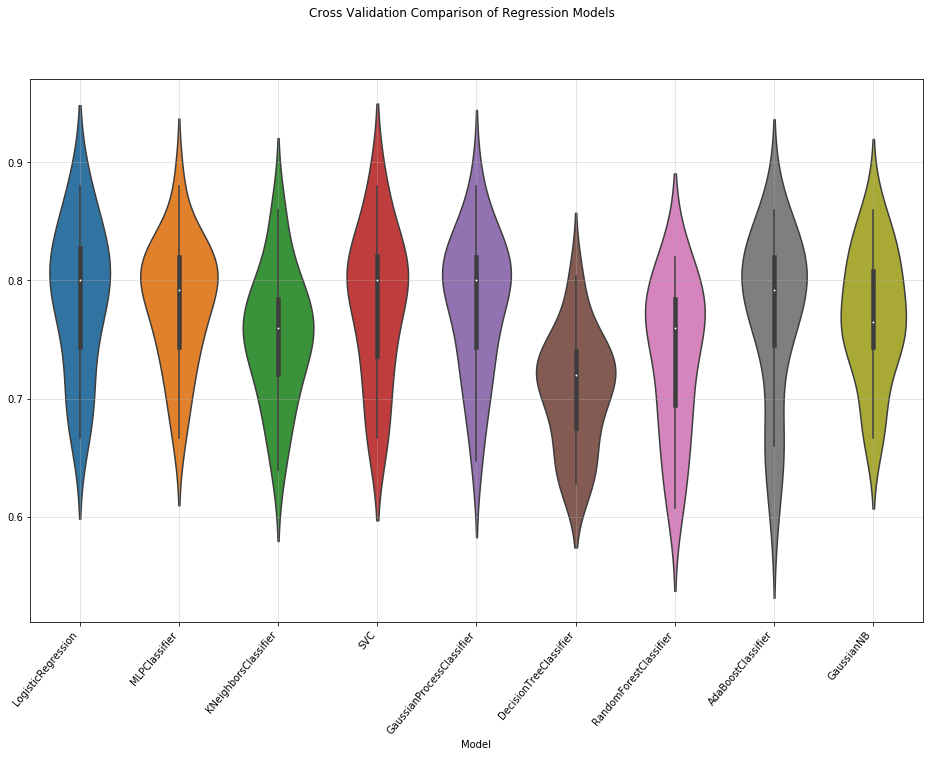

In [172]:
# Initial Cross Validation
models = []
models.append(LogisticRegression())
models.append(MLPClassifier(hidden_layer_sizes=(1000)))
models.append(KNeighborsClassifier())
models.append(SVC())
models.append(GaussianProcessClassifier())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(AdaBoostClassifier())
models.append(GaussianNB())

class_crossval_plot(X_train, y_train, models, splits=20)

## Choose Model

In [ ]:
params = {}
grid = GridSearchCV(LogisticRegression, params, n_jobs=-1)

In [180]:
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
actual = y_test
correct = 0
for i in range(0, len(pred)):
    if pred[i] == actual[i]:
        correct += 1
correct / len(pred)

0.7619047619047619

## Predict

In [184]:
seeds_2018 = pd.read_csv('WStage2DataFiles/WNCAATourneySeeds.csv')

In [196]:
modelTable2 = pd.DataFrame(columns=model_cols)
teams = seeds_2018[ seeds_2018.Season == 2018 ].TeamID.values
tt_filt = tt_reset[ tt_reset.Season == 2018 ]
for a, b in combinations(teams, 2):
    if int(a) < int(b):
        lowID = a
        highID = b
    else:
        lowID = b
        highID = a
    diff2 = tt_filt[ tt_filt.TeamID == lowID][model_cols].values - tt_filt[ tt_filt.TeamID == highID][model_cols].values
    diff2 = pd.DataFrame(diff2, columns=model_cols)
    modelTable2 = modelTable2.append(diff2, ignore_index=True)

In [ ]:
model